# Air Quality Analysis 



## 1. Dataset and Knowledge Preparation

The provided dataset contains measurements of air quality from a multisensor device. The device used spectrometer analyzers (variables marked by "GT") and solid state metal oxide detectors (variables marked by "PT08.Sx"), as well as temperature (T), relative humidity (RH) and absolute humidity (AH) sensors. 

The dataset contains 3304 instances of hourly averaged measurements taken at road level in a polluted city. You will predict the CO(GT) variable representing carbon monoxide levels. There are missing features in this dataset, flagged by the number `-999`. 

You will need to pre-process the dataset to handle missing features, for which please self-learn from scikit-learn on how to [impute missing values](https://scikit-learn.org/stable/modules/impute.html). You will need to split the dataset into training and testing sets, also to run cross validation, when you see fit. For this, please self-learn from scikit-learn on [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).   

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import sklearn.model_selection

notebook_start_time = time.time()

# Import data - it should be saved in the same root directory as this notebook
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(5)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
2486,1.6,1049.00,6.585113,838.50,103.0,845.50,110.0,1635.75,858.00,28.525,41.600000,1.595949
492,2.0,1020.75,5.918707,808.00,224.0,961.00,102.0,1048.25,1097.50,7.900,59.200001,0.633073
1331,2.2,1133.75,7.136442,862.75,120.0,868.50,88.0,1598.75,1009.00,12.525,81.799999,1.183764
2749,1.0,1024.75,3.368542,674.50,160.1,798.00,88.8,1256.75,828.25,15.000,73.249998,1.241344
1714,2.1,1147.75,12.499074,1066.75,133.0,887.25,105.0,1789.75,955.50,23.625,40.950001,1.178587


## 2. Linear Classification via Gradient Descent 

The air quality is assessed using the CO(GT) variable. If it is no greater than 4.5, the air quality is good (CO(GT)<=4.5), otherwise, it is bad  (CO(GT)>4.5). You will perform binary classification to predict whether the air quality is good based on the other 11 varivables, i.e., from PT08.S1(CO) to AH. 

### 2.1 Model Training and Testing 

This practice is about training a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation, and then testing its performance. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is 

$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

Recall from your lectures that gradient descent is an iterative optimisation algorithm typically used in model training. Complete the implmentation of the training function `linear_gd_train` below, which trains your linear model by minimising the above provided training objective function $O$ using gradient descent.

The function should return the trained model weights and the corresponding objective function value (referred to as cost) per iteration. In addition to the training data, the function should take the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A default setting of these parameters has been provided below, which is able to provide reasonably good performance.  

**Note that scikit-learn is not allowed for implementation in this section.** We recommend that you avoid using `for` loops in your implementation of the objective function or weight update, and instead use built-in numpy operations for efficiency. 

In [2]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.001, random_state=None):
    """
    A summary of your function goes here.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent

    Returns an array of cost and model weights per iteration.
    """
    # Set random seed for reproducibility if using random initialization of weights (optional)
    rng = np.random.default_rng(seed=random_state)

    # Create design matrix and labels
    X_tilde = np.hstack([np.ones((data.shape[0], 1)), data])
    y = 2 * labels - 1

    # Weight initialization: use e.g. rng.standard_normal() or all zeros
    w = rng.standard_normal(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((n_iters, X_tilde.shape[1]))
    cost_all = np.zeros(n_iters)

    # GD update of weights
    for i in range(n_iters):
        # Cost and gradient update of the linear model
        margins = y * (X_tilde @ w)
        losses = np.maximum(0, 1 - margins)
        cost = c * np.sum(losses) + 0.5 * np.linalg.norm(w)**2
        cost_all[i] = cost

        indicator = (margins < 1).astype(int)
        gradient = -c * (X_tilde.T @ (indicator * y)) + w

        # Weight update
        w -= learning_rate * gradient
        w_all[i] = w

    # Return model parameters.
    return cost_all, w_all



def linear_predict(data, w):
    """
    A summary of your function goes here.

    data: test data
    w: model weights

    Returns the predicted labels.
    """

    X_tilde = np.hstack([np.ones((data.shape[0], 1)), data])
    predictions = X_tilde @ w
    y_pred = (predictions > 0).astype(int)
    
    return y_pred

Now, you are ready to conduct a complete experiment of air quality classification. The provided code below splits the data into training and testing sets and imputes the missing features. 

In [3]:
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

Write your code below, which should train the model, plot the training objective function value and the classification accuracy of the training set over iterations, and print the classification accuracy and $F_1$ score of the testing set. Note, use the default setting provided for $C$, $\eta$ and $N_{max}$. Your plot should have axis labels and titles.

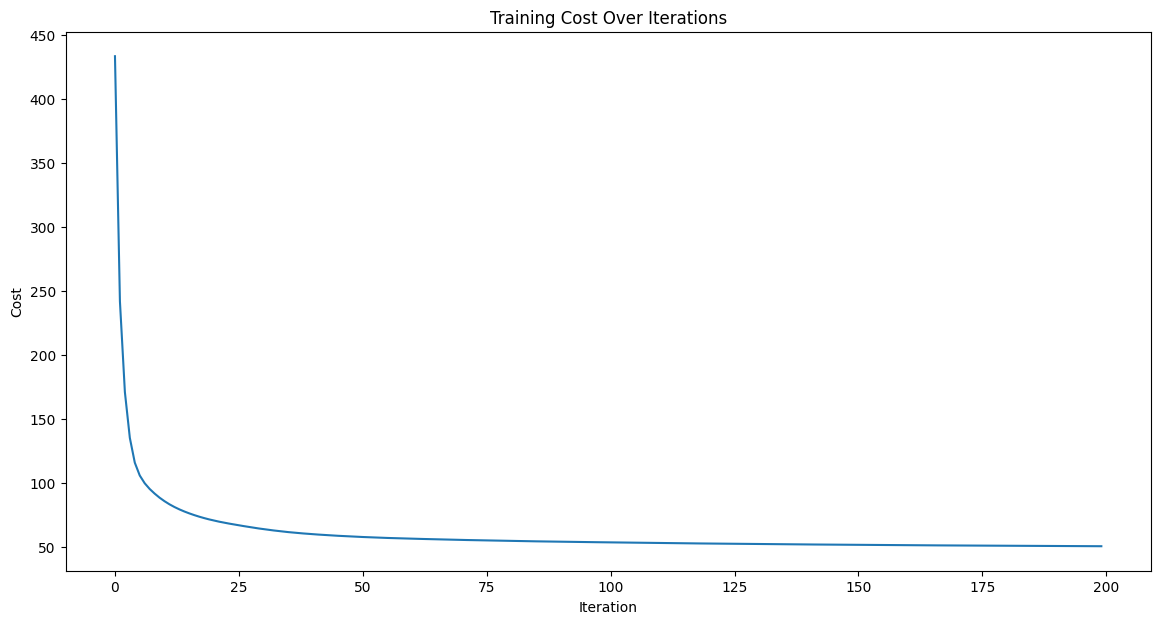

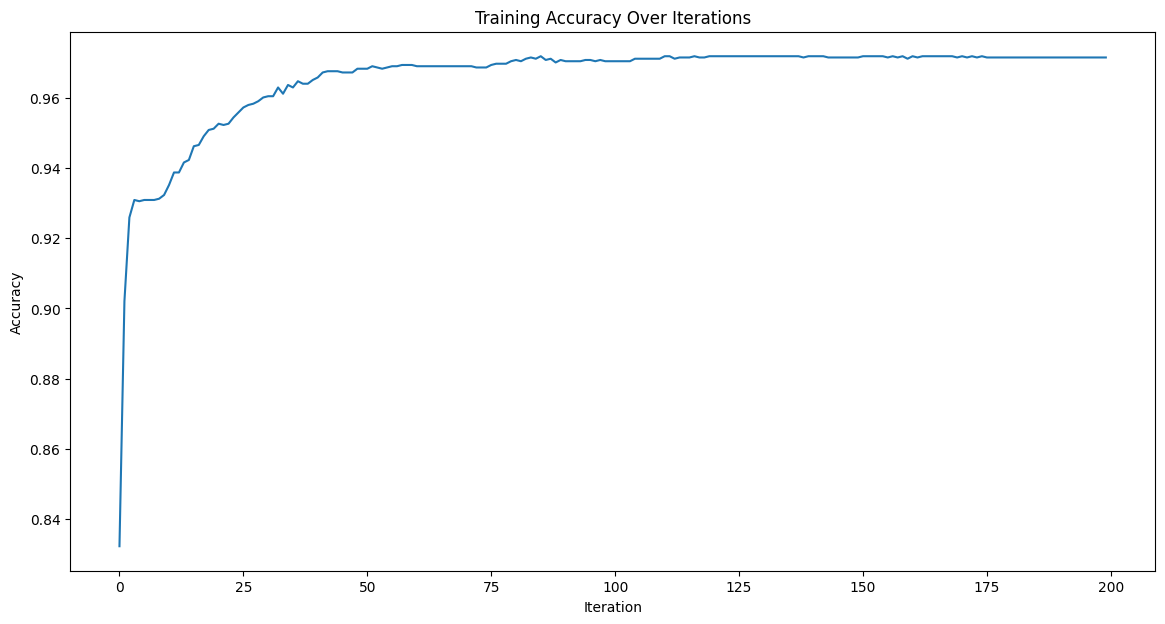

Test Accuracy: 0.9616935483870968
Test F1 Score: 0.627450980392157


In [4]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, f1_score
def calculate_accuracy(true_labels, predictions):
    correct = np.sum(true_labels == predictions)
    return correct / len(true_labels)



def custom_f1_score(y_true, y_pred, pos_label=1):
    """
    Calculate the F1 score for binary classification.
    
    Parameters:
    - y_true (array-like): True class labels.
    - y_pred (array-like): Predicted class labels.
    - pos_label (int or str): The label considered as positive (default is 1).
    
    Returns:
    - f1 (float): The F1 score.
    """
    # Ensure inputs are NumPy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    tp = np.sum((y_pred == pos_label) & (y_true == pos_label))
    fp = np.sum((y_pred == pos_label) & (y_true != pos_label))
    fn = np.sum((y_pred != pos_label) & (y_true == pos_label))

    # Precision and Recall calculations
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # F1 Score calculation
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return f1




# Train the model
costs, weights = linear_gd_train(train_X_cls, train_y_cls)

# Plot training cost over iterations
plt.figure(figsize=(14, 7))
plt.plot(costs)
plt.title('Training Cost Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

# Plot accuracy per iteration on training set
train_accuracy = []
for i in range(len(weights)):
    predictions_train = linear_predict(train_X_cls, weights[i])
    train_accuracy.append(calculate_accuracy(train_y_cls, predictions_train))

plt.figure(figsize=(14, 7))
plt.plot(train_accuracy)
plt.title('Training Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

# Apply imputation to the test set and standardize
test_X_cls = imputer.transform(test_X_cls)
test_X_cls = scaler.transform(test_X_cls)

# Predict on test set
predictions_test = linear_predict(test_X_cls, weights[-1])
test_accuracy = calculate_accuracy(test_y_cls, predictions_test)
test_f1 = custom_f1_score(test_y_cls, predictions_test, pos_label=1)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')


### 2.2 Learning Rate Analysis 

The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. Design an appropriate experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

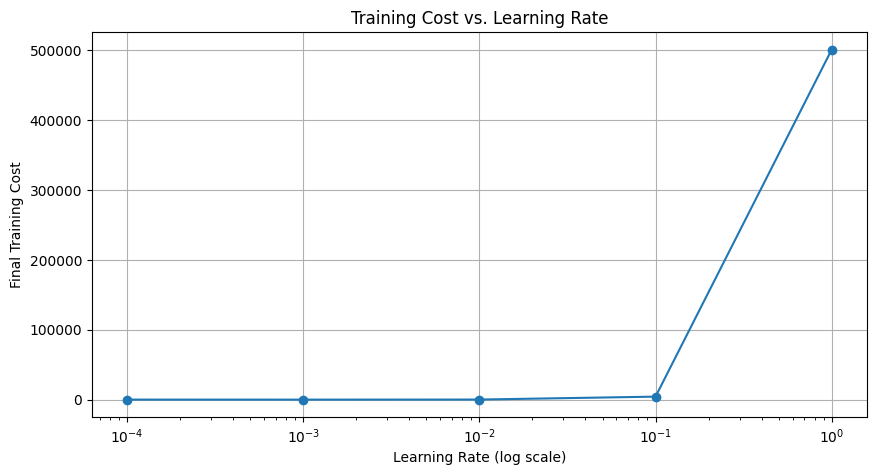

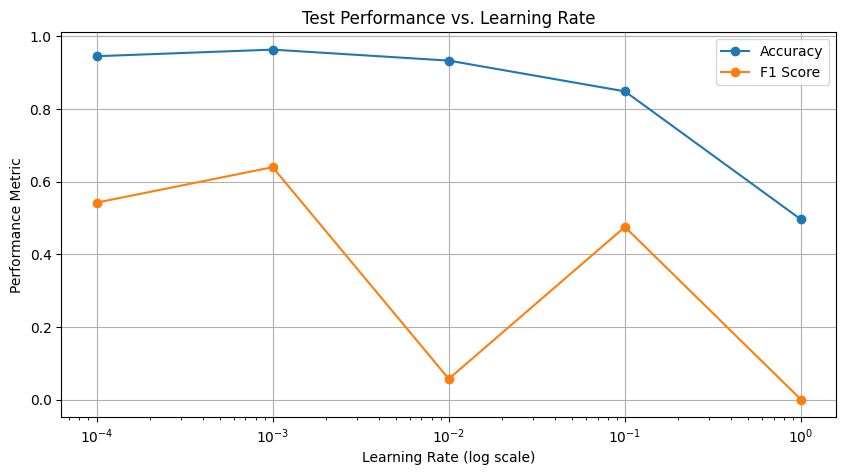

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Define a range of learning rates to test
learning_rates = [0.0001, 0.001, 0.01, 0.1,1]

# Initialize lists to store results
train_costs = []
test_accuracies = []
test_f1_scores = []

# Train and evaluate the model for each learning rate
for eta in learning_rates:
    # Train the model
    costs, weights = linear_gd_train(train_X_cls, train_y_cls, learning_rate=eta)
    
    # Record training cost over iterations
    train_costs.append(costs[-1])
    
    # Predict on test set
    predictions_test = linear_predict(test_X_cls, weights[-1])
    
    # Evaluate performance on test set
    test_accuracy = accuracy_score(test_y_cls, predictions_test)
    test_f1 = f1_score(test_y_cls, predictions_test)
    
    # Record test performance
    test_accuracies.append(test_accuracy)
    test_f1_scores.append(test_f1)

# Plot training cost over iterations for each learning rate
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, train_costs, marker='o')
plt.xscale('log')
plt.title('Training Cost vs. Learning Rate')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Final Training Cost')
plt.grid(True)
plt.show()

# Plot test accuracy and F1 score for each learning rate
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, test_accuracies, marker='o', label='Accuracy')
plt.plot(learning_rates, test_f1_scores, marker='o', label='F1 Score')
plt.xscale('log')
plt.title('Test Performance vs. Learning Rate')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Performance Metric')
plt.legend()
plt.grid(True)
plt.show()